In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime
import random
import crossval #this is the file Eli wrote



from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, RandomForestClassifier, BaggingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, balanced_accuracy_score, plot_precision_recall_curve, precision_recall_curve, precision_score, recall_score

from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.inspection import permutation_importance
import shap
import lightgbm as lgb 

pd.set_option('max_colwidth', 80)

In [6]:
sea_df = pd.read_csv("compat_sea.csv")
tac_df = pd.read_csv("compat_tac.csv")

In [7]:
train_sea = sea_df[~sea_df["Process_year"].eq(2020)]
train_tac = tac_df[~tac_df["Process_year"].eq(2020)]
val_sea = sea_df[sea_df["Process_year"].eq(2020)]
val_tac = tac_df[tac_df["Process_year"].eq(2020)]

In [8]:
param_list = {
      'n_estimators': [50],
      'max_depth': [30],
      'verbose': [True],
      'class_weight': ['balanced']
    } 
param = {}
for key in param_list.keys():
    val = random.choice(param_list[key])
    param[key] = val

In [9]:
# Used to build a list containing dictionaries w every compination of params
# from param list, start with a list containing one dict (src), 
# then call for each param (cross, keyword)
def cross_params(src, cross, keyword):
    combos = []
    for d in src:
        for val in cross:
            cpy = d.copy()
            cpy[keyword] = val
            combos.append(cpy)
    return combos

# Uses cross_params to get list of all parameter combinations 
def get_param_combos(param_list):
    param_combos = [{}]
    for kw in param_list:
        param_combos = cross_params(param_combos, param_list[kw], kw)
    return param_combos

{'n_estimators': 50, 'max_depth': 30, 'verbose': True, 'class_weight': 'balanced'}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   27.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished


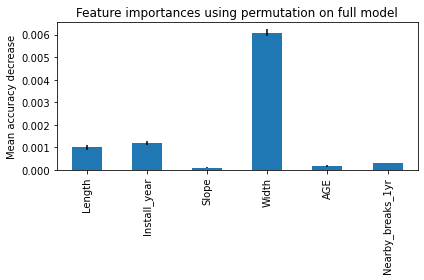

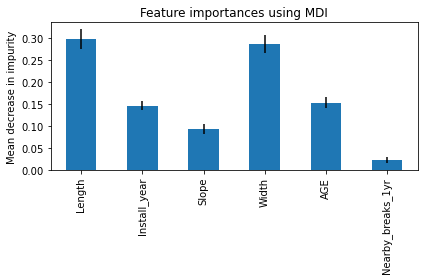

In [11]:
for params in get_param_combos(param_list):
    print(params)
    classifier = RandomForestClassifier()
    classifier.set_params(**params)

    # use all years for training data
    train_df = train_sea.drop(['TARGET_FID', 'Process_year', 'Break_Yr'], axis=1) \
                    .dropna(axis=0) \
                    .astype(np.float32)

    year_val = val_sea.drop(['TARGET_FID', 'Process_year', 'Break_Yr'], axis=1) \
        .dropna(axis=0) \
        .astype(np.float32)
    # fit to training data
    x_train = train_df.drop('Target', axis=1)
    y_train = train_df['Target']

    # make predictions on evaluation dataset
    x_val = year_val.drop('Target', axis=1)
    y_val = year_val['Target']
    
    classifier.fit(x_train, y_train)

    result = permutation_importance(
        classifier, x_val, y_val, n_repeats=10, random_state=42, n_jobs=2)

    forest_importances = pd.Series(result.importances_mean, index=x_val.columns.values)

    importances = classifier.feature_importances_
    std = np.std([
    tree.feature_importances_ for tree in classifier.estimators_], axis=0)


    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show
    forest_importances = pd.Series(importances, index=x_val.columns.values)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.show()

    print('STARTING SHAP CALCULATIONS')
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer(x_train)
    shap.plots.bar(shap_values)
